In [1]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = '../Lumpy Skin Images Dataset'

In [3]:

datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 922 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [4]:

base_model = MobileNetV2(weights=None, include_top=False, input_shape=(256, 256, 3))

base_model.load_weights('../mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [5]:

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax') 
])

In [6]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_256 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 3,571,778
Trainable params: 1,313,794
Non-

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
batch_size = 32
epochs = 10

train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 28
validation_steps : 3


In [11]:
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7562
Epoch 1: val_accuracy improved from -inf to 0.77083, saving model to .\model_01-0.77.h5
28/28 [==============================] - 40s 1s/step - loss: 0.5338 - accuracy: 0.7562 - val_loss: 0.4841 - val_accuracy: 0.7708
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8719
Epoch 2: val_accuracy improved from 0.77083 to 0.86458, saving model to .\model_02-0.86.h5
28/28 [==============================] - 27s 947ms/step - loss: 0.3222 - accuracy: 0.8719 - val_loss: 0.3243 - val_accuracy: 0.8646
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8742
Epoch 3: val_accuracy did not improve from 0.86458
28/28 [==============================] - 27s 976ms/step - loss: 0.3224 - accuracy: 0.8742 - val_loss: 0.3102 - val_accuracy: 0.8646
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8978
E

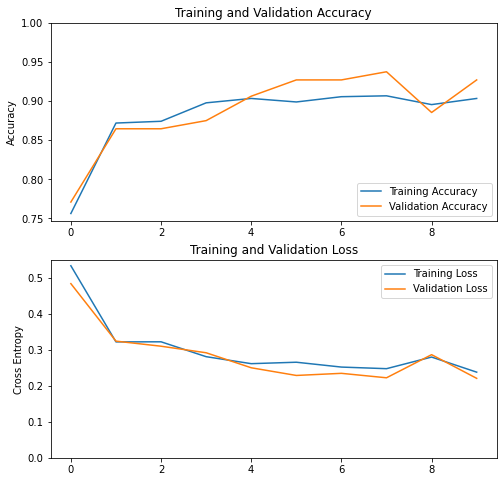

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:

test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

4/4 [==============================] - 2s 457ms/step - loss: 0.2314 - accuracy: 0.9216
test accuracy :  0.9215686321258545


In [14]:
loaded_best_model = keras.models.load_model("./model_05-0.92.h5")

def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

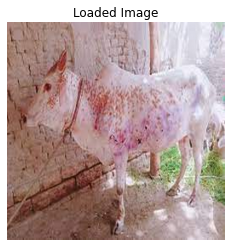



Maximum Probability:  0.9381519
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 93.82 %
NORMAL SKIN : 6.18 %


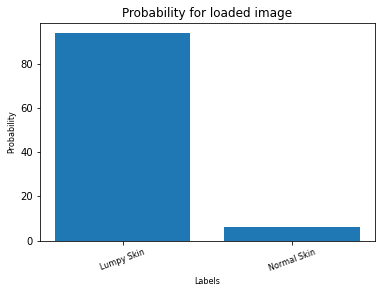

In [15]:
predict("../Lumpy Skin Images Dataset//Lumpy Skin/Lumpy_Skin_64.png")

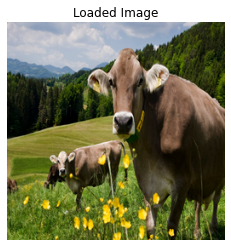



Maximum Probability:  0.9751037
Classified: Normal Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 2.49 %
NORMAL SKIN : 97.51 %


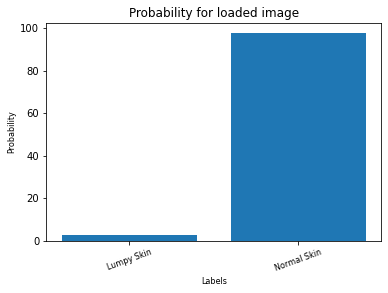

In [16]:
predict("../Lumpy Skin Images Dataset/Normal Skin/Normal_Skin_4.png")